In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import sqlalchemy
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [7]:
password = 'dimVuidBun1onCub'
login = 'a.al.kosheleva'

def postre_auth(login, password):
    postgresql_config = {
    'postgresql_prefix' : 'postgresql'
    , 'postgresql_host'   : '10.3.26.92' 
    , 'postgresql_user'   : f'{login}'
    , 'postgresql_pass'   : f'{password}'
    , 'postgresql_port'   : '5432'
    , 'postgresql_db'     : 'dwh'    
    }

    postgresql_connection_string  = "{prefix}://{user}:{passw}@{host}:{port}/{db}".format(
    prefix  =   postgresql_config['postgresql_prefix']    , host  =   postgresql_config['postgresql_host']
    , user  =   postgresql_config['postgresql_user']      , passw =   postgresql_config['postgresql_pass']
    , port  =   postgresql_config['postgresql_port']      , db    =   postgresql_config['postgresql_db']
    )
    postgresql_engine = sqlalchemy.create_engine(postgresql_connection_string)
    postgresql_conn   = postgresql_engine.connect()
    return postgresql_engine, postgresql_conn

postrgre_engine, postrge_conn = postre_auth(login, password)

In [8]:
results = '''
with

orders AS (
select distinct date(created) as date, pav_order_id
from dwh_datamart.ops_metrics
where (date(created) between '2023-04-25' AND '2023-04-28' or date(created) between '2023-04-18' AND '2023-04-21')
and flag_cancel = 0 and order_source IN ('iOS', 'Android')
and retail_brand = 'lo'
),

t1 as (
select
  extract('week' from date) as week,
  original_id,
  sum(zit.price*zit.count_courier*zit.denominator/zit.numerator) as revenue
from orders z
inner join dwh_stage.utk_sess_zakaz_items zit
on zit.pav_order_id = z.pav_order_id
where original_id IN (
'346643',
 '434165',
 '045003',
 '060371',
 '060375',
 '122563',
 '533459',
 '369199',
 '099411',
 '517570',
 '640027',
 '591241',
 '515944',
 '448707',
 '517562',
 '317444',
 '448709',
 '099679',
 '149868',
 '060367',
 '078950',
 '354087',
 '471479',
 '519751',
 '099880',
 '354168',
 '593374',
 '610101',
 '578571',
 '481251',
'065236',
 '543805',
 '520163',
 '569437',
 '453027',
 '666913',
 '431488',
 '667332',
 '481250',
 '099882',
 '481252',
 '149776',
 '640298',
 '149487',
 '060374',
 '593375',
 '520555',
 '387930',
 '099410',
 '045004',
 '453208',
 '116414',
 '431490',
 '448708',
 '453845',
 '354085',
 '543923'
    )
group by 1,2
)

select week,
       case when original_id in (
           '346643',
 '434165',
 '045003',
 '060371',
 '060375',
 '122563',
 '533459',
 '369199',
 '099411',
 '517570',
 '640027',
 '591241',
 '515944',
 '448707',
 '517562',
 '317444',
 '448709',
 '099679',
 '149868',
 '060367',
 '078950',
 '354087',
 '471479',
 '519751',
 '099880',
 '354168',
 '593374',
 '610101',
 '578571',
 '481251'
           ) then 'test' else 'control' end as groups,
    sum(revenue) as revenue
from t1
group by 1,2
order by 1,2'''

In [9]:
result_table = pd.read_sql(results, postrge_conn)

In [14]:
result_table

,week,groups,revenue
0,16.0,control,142930.976813
1,16.0,test,185362.278507
2,17.0,control,173417.875660
3,17.0,test,141721.425340


In [15]:
#запрос для выгрузки продаж по скю
sql = '''
with 

orders AS (
select distinct buyer_id, pav_order_id, date(created) as date
from dwh_datamart.ops_metrics
where date(created) between '2023-02-20' AND '2023-04-28'
and flag_cancel = 0 and order_source IN ('iOS', 'Android')
and retail_brand = 'lo'
),

t1 as (
select
  date, zit.original_id,
  sum(zit.count_courier*zit.denominator/zit.numerator) as revenue
from orders z
inner join dwh_stage.utk_sess_zakaz_items zit
on zit.pav_order_id = z.pav_order_id
group by 1,2
)

select *, sum(revenue) over(partition by original_id) as total_sku_revenue
from t1
'''

In [16]:
needed_skus = pd.read_excel('C:/Users/a.al.kosheleva/analytics/kosheleva_a/files/nuts.XLSX', dtype = 'str')

In [17]:
filter_skus = needed_skus.original_id.to_list()

In [18]:
all_cats_pre = pd.read_sql(sql, postrge_conn)

In [19]:
all_cats = all_cats_pre.query("original_id == @filter_skus")

In [20]:
all_cats

,date,original_id,revenue,total_sku_revenue
31381,2023-02-21,045003,1.840000,245.386667
31382,2023-03-06,045003,5.620000,245.386667
31383,2023-04-18,045003,1.913333,245.386667
31384,2023-03-22,045003,4.253333,245.386667
31385,2023-04-21,045003,2.546667,245.386667
...,...,...,...,...
1947258,2023-04-24,682537,5.000000,35.000000
1947259,2023-04-20,682537,2.000000,35.000000
1947260,2023-04-12,682537,2.000000,35.000000
1947261,2023-04-11,682537,1.000000,35.000000


In [21]:
all_cats['date'] = pd.to_datetime(all_cats['date'])

C:\Users\AAL~1.KOS\AppData\Local\Temp/ipykernel_17500/1274449376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_cats['date'] = pd.to_datetime(all_cats['date'])


In [101]:
#выделяем пилот и предпилот
df_prepilot = all_cats.loc[(all_cats['date'] <= '2023-04-23')&(all_cats['date'] >= '2023-03-23')].copy()
df_pilot = all_cats.loc[all_cats['date'] > '2023-04-23'].copy()

In [102]:
df_sku_sales = df_prepilot.pivot_table(index = 'original_id', aggfunc = {'revenue':'sum'}).reset_index()

In [103]:
list_sku = df_sku_sales.loc[(df_sku_sales['revenue']>= df_sku_sales['revenue'].quantile(0.6))&(df_sku_sales['revenue']<= df_sku_sales['revenue'].quantile(0.95))]['original_id'].tolist()

In [104]:
df_prepilot = df_prepilot.loc[df_prepilot['original_id'].isin(list_sku)].reset_index().copy()

In [105]:
df_pilot = df_pilot.loc[df_pilot['original_id'].isin(list_sku)].reset_index().copy()

In [106]:
len(list_sku)

61

In [107]:
from sklearn.metrics import mean_squared_error#(y_true, y_pred

In [29]:
from IPython.display import clear_output

In [235]:
#функция для подбора лучших теста и контроля
def best_sample(df, l_sku, n_inter, n_sku):
    iterations = n_inter #число итераций
    var = 100000000000
    
    sample_test_final = []
    sample_control_final = []
    best_iter = 0

    for i in range(iterations):
        print(i, end = ' ')
        clear_output(wait=True)
        df_split = pd.DataFrame({
            'sku':random.sample(list_sku, n_sku),
            'ab_group':np.random.randint(0,2,n_sku)
        })
        sample_try_test = df_split.query('ab_group==1')['sku'].tolist() #рандомный тест
        sample_try_control = df_split.query('ab_group==0')['sku'].tolist()#рандомный контроль
        
        #собираем агрегаты по датам с суммой продаж в штуках
        test_group_check = df.loc[df['original_id'].isin(sample_try_test)] \
            .groupby('date') \
            .agg({'revenue':'sum'}).reset_index()
        
        control_group_check = df.loc[df['original_id'].isin(sample_try_control)] \
            .groupby('date') \
            .agg({'revenue':'sum'}).reset_index()
        
        df_for_diff = test_group_check.merge(control_group_check, how = 'left', on = 'date')#джойн
        #new_var = mean_squared_error(df_for_diff.revenue_x, df_for_diff.revenue_y)**(1/2)
        new_var = np.std(df_for_diff.revenue_x - df_for_diff.revenue_y)
        if new_var < var:#сохраняем лучший сплит
            var = new_var
            sample_test_final = sample_try_test
            sample_control_final = sample_try_control
            best_iter = i
        
    return sample_try_test, sample_try_control, best_iter

In [301]:
result = best_sample(df_prepilot, list_sku, 3000, 58)

2999 

In [302]:
#забираем тест и контроль из функции
final_test = result[0]
final_control = result[1]

test_and_control = final_test + final_control

In [108]:
final_test = ['346643',
 '434165',
 '045003',
 '060371',
 '060375',
 '122563',
 '533459',
 '369199',
 '099411',
 '517570',
 '640027',
 '591241',
 '515944',
 '448707',
 '517562',
 '317444',
 '448709',
 '099679',
 '149868',
 '060367',
 '078950',
 '354087',
 '471479',
 '519751',
 '099880',
 '354168',
 '593374',
 '610101',
 '578571',
 '481251']
final_control = ['065236',
 '543805',
 '520163',
 '569437',
 '453027',
 '666913',
 '431488',
 '667332',
 '481250',
 '099882',
 '481252',
 '149776',
 '640298',
 '149487',
 '060374',
 '593375',
 '520555',
 '387930',
 '099410',
 '045004',
 '453208',
 '116414',
 '431490',
 '448708',
 '453845',
 '354085',
 '543923']

test_and_control = final_test + final_control

In [109]:
#фильтруем наши исходные датафреймы по скю для теста и контроля, присваиваем группы
all_cats_final = pd.DataFrame(all_cats.query('original_id == @test_and_control')).copy()
df_prepilot_final = pd.DataFrame(df_prepilot.query('original_id == @test_and_control')).copy()
df_pilot_final = pd.DataFrame(df_pilot.query('original_id == @test_and_control')).copy()

all_cats_final['groups'] = all_cats_final.original_id.apply(lambda x: 'test' if x in final_test else 'control')
df_prepilot_final['groups'] = df_prepilot_final.original_id.apply(lambda x: 'test' if x in final_test else 'control')
df_pilot_final['groups'] = df_pilot_final.original_id.apply(lambda x: 'test' if x in final_test else 'control')

In [110]:
#датафрейм для визуализации
vis_groups = all_cats_final.groupby(['groups', 'date']).agg({'revenue':'sum'}).rename(columns = {'revenue':'revenue_sum'}).reset_index()

In [111]:
sc = StandardScaler()

In [112]:
#стандартизируем метрики для визуализации
vis_groups_test = vis_groups.loc[vis_groups['groups'] == 'test']
vis_groups_control = vis_groups.loc[vis_groups['groups'] == 'control']

vis_groups_test['rev_standart'] = sc.fit_transform(vis_groups_test[['revenue_sum']])
vis_groups_control['rev_standart'] = sc.fit_transform(vis_groups_control[['revenue_sum']])    

vis_final = pd.concat([vis_groups_test, vis_groups_control])

C:\Users\AAL~1.KOS\AppData\Local\Temp/ipykernel_17500/2588219708.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AAL~1.KOS\AppData\Local\Temp/ipykernel_17500/2588219708.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='date', ylabel='rev_standart'>

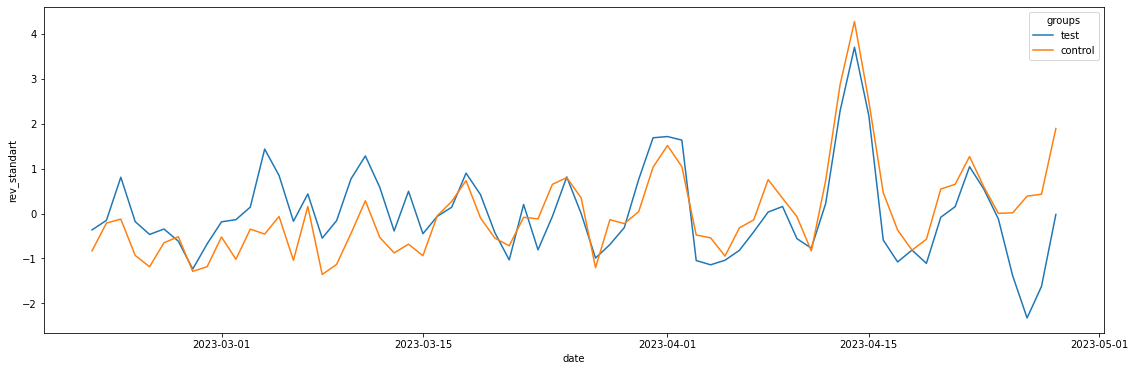

In [113]:
f = plt.figure(figsize=(19, 6))
sns.lineplot(data=vis_final, x="date", y="rev_standart", hue = 'groups', ci=None)

In [114]:
#готовим данные для моделирования по продажам в штуках на наших группах
mtr = 'revenue'
corr_lim = 0, # лимит корреляции

sigma = 1.5
y_train = df_prepilot_final.loc[
    df_prepilot_final['groups'] == 'test'
].pivot_table(index='date', aggfunc={mtr:'sum'})[[mtr]].values
X_train = df_prepilot_final.loc[
    df_prepilot_final['groups'] == 'control'
].pivot_table(index='date', aggfunc={mtr:'sum'}).reset_index()[[mtr]].values
X_train = sm.add_constant(X_train)
    
y_test = df_pilot_final.loc[
    df_pilot_final['groups'] == 'test'
].pivot_table(index='date', aggfunc={mtr:'sum'})[[mtr]].values
X_test = df_pilot_final.loc[
    df_pilot_final['groups'] == 'control'
].pivot_table(index='date', aggfunc={mtr:'sum'}).reset_index()[[mtr]].values
X_test = sm.add_constant(X_test)
    
# обучаем модель
model = sm.OLS(y_train, X_train)
results = model.fit()

In [115]:
    # оцениваем точность модели
    float_rsquared = round(results.rsquared, 4)
    series_predictions = pd.Series(results.predict(X_test))
    series_facts = pd.Series([i[0] for i in y_test])
    series_prepilot_predictions = pd.Series(results.predict())
    series_prepilot_facts = pd.Series([i[0] for i in y_train])
    rmse = mean_squared_error(series_predictions, series_facts)**(1/2)
    rmse_prec = round(rmse / series_predictions.mean(), 4)
    print(f'R-squared: {float_rsquared}, holdout {sigma} rmse (%): {sigma * rmse_prec}')

    # визуализация точности прогнозирования
    t_prepilot = [i + 1 for i in range(len(series_prepilot_predictions))]
    t_pilot = [i + 1 for i in range(max(t_prepilot), max(t_prepilot) + len(series_predictions))]
    df_pilot_pred = pd.DataFrame({
        'data_type':'forecast',
        'period_type':'pilot',
        'values':series_predictions,
        'ci_low':series_predictions - rmse * sigma,
        'ci_up':series_predictions + rmse * sigma,
        't':t_pilot
    })
    df_pilot_fact = pd.DataFrame({
        'data_type':'fact',
        'period_type':'pilot',
        'values':series_facts,
        'ci_low':series_predictions - rmse * sigma,
        'ci_up':series_predictions + rmse * sigma,
        't':t_pilot
    })
    df_prepilot_pred = pd.DataFrame({
        'data_type':'forecast',
        'period_type':'prepilot',
        'values':series_prepilot_predictions,
        'ci_low':series_prepilot_predictions - rmse * sigma,
        'ci_up':series_prepilot_predictions + rmse * sigma,
        't':t_prepilot
    })
    df_prepilot_fact = pd.DataFrame({
        'data_type':'fact',
        'period_type':'prepilot',
        'values':series_prepilot_facts,
        'ci_low':series_prepilot_predictions - rmse * sigma,
        'ci_up':series_prepilot_predictions + rmse * sigma,
        't':t_prepilot
    })
    df_results = pd.concat([df_prepilot_fact, df_prepilot_pred, df_pilot_fact, df_pilot_pred])
    fig = px.line(
        df_results, 
        x="t", 
        y=['ci_low', "values", 'ci_up'], 
        color='data_type',
        color_discrete_sequence=["blue", "orange"]
    )
    fig.add_vline(
        x=min(t_pilot), 
        line_width=2, 
        line_dash="dash", 
        line_color="black", 
        opacity=0.7,
        annotation_text="A/A period start", 
        annotation_position="top left"
    )
    fig.show()

R-squared: 0.8724, holdout 1.5 rmse (%): 0.5838


In [116]:
series_predictions.sum()

1260.6967075831844

In [117]:
series_facts.sum()

846.5326666666666

In [118]:
series_predictions.sum()/series_facts.sum()*100-100

48.924755916076236

In [119]:
series_predictions

0    219.913997
1    214.891201
2    235.215230
3    243.930921
4    346.745359
dtype: float64

In [120]:
df_prepilot_final.date.max()

Timestamp('2023-04-23 00:00:00')

In [121]:
df_pilot_final.date.min()

Timestamp('2023-04-24 00:00:00')

In [ ]:
#скрипт с регрессией

In [145]:
for_lin_regr = pd.DataFrame(all_cats_final.groupby('date').revenue.sum()).reset_index()

In [146]:
import plotly.express as px

In [147]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [148]:
len(for_lin_regr['date'])

68

In [150]:
for_lin_regr = for_lin_regr.reset_index()

In [151]:
X = for_lin_regr['index']
y = for_lin_regr['revenue']

In [152]:
model_linal = sm.OLS(y, X)
result = model_linal.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                revenue   R-squared (uncentered):                   0.757
Model:                            OLS   Adj. R-squared (uncentered):              0.753
Method:                 Least Squares   F-statistic:                              208.3
Date:                Wed, 21 Jun 2023   Prob (F-statistic):                    3.05e-22
Time:                        16:15:57   Log-Likelihood:                         -468.19
No. Observations:                  68   AIC:                                      938.4
Df Residuals:                      67   BIC:                                      940.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [153]:
for_lin_regr['revenue_predict'] = result.predict(for_lin_regr['revenue'])

In [154]:
for_lin_regr

,level_0,index,date,revenue,revenue_predict
0,0,0,2023-02-20,382.782667,4112.467813
1,1,1,2023-02-21,439.439333,4721.164963
2,2,2,2023-02-22,505.005333,5425.580518
3,3,3,2023-02-23,386.907333,4156.781625
4,4,4,2023-02-24,351.510667,3776.493631
...,...,...,...,...,...
63,63,63,2023-04-24,456.883333,4908.576501
64,64,64,2023-04-25,379.125333,4073.174849
65,65,65,2023-04-26,347.377333,3732.086708
66,66,66,2023-04-27,393.879333,4231.686076


In [155]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [156]:
def error(y_true,y_pred):
    print(mean_absolute_error(y_true,y_pred))
    print(mean_absolute_percentage_error(y_true,y_pred))

In [157]:
error(for_lin_regr.revenue, for_lin_regr.revenue_predict)

4519.208459066906
9.743610333951164
